<a href="https://colab.research.google.com/github/yoonju977/Digital-Image-Processing/blob/main/Lab09_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder, DatasetFolder
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


## Download MNIST and Prepare Data Loader

In [4]:
path0 = '.'

transform = v2.Compose(
    [
        v2.ToTensor(),
        v2.Grayscale(),
        v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
        v2.RandomCrop(size=(28, 28)),
        ]
    )

transform_val = v2.Compose(
    [
        v2.ToTensor(),
        v2.Grayscale(),
        v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
        v2.CenterCrop(size=(28, 28)),
        ]
    )

mnist_train = torchvision.datasets.MNIST(path0, train=True, transform=transform, target_transform=None, download=True)
mnist_valid = torchvision.datasets.MNIST(path0, train=False, transform=transform_val, target_transform=None, download=True)
def get_mnist_labels(labels):
    text_labels = ['0', '1', '2', '3', '4',
                   '5', '6', '7', '8', '9']
    return [text_labels[int(i)] for i in labels]

# defining data_iter, linreg. model, loss, sgd
batch_size = 100
num_workers = 0
train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
valid_iter = DataLoader(mnist_valid, batch_size, shuffle=False, num_workers=num_workers)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.2MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.50MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
                 ToTensor()
                 Grayscale(num_output_channels=1)
                 ToDtype(scale=True)
                 RandomCrop(size=(28, 28), pad_if_needed=False, fill=0, padding_mode=constant)
           )

In [6]:
mnist_valid

Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
                 ToTensor()
                 Grayscale(num_output_channels=1)
                 ToDtype(scale=True)
                 CenterCrop(size=(28, 28))
           )

torch.Size([100])
torch.Size([100, 1, 28, 28])


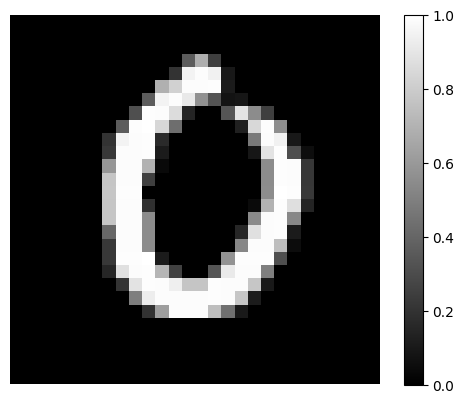

['0']


In [7]:
for images, labels in train_iter:
  print(labels.shape)
  print(images.shape)
  I = images[0].numpy()
  plt.figure(dpi=100)
  plt.imshow(I[0],cmap='gray')
  plt.axis('off')
  plt.colorbar()
  plt.show()
  print(get_mnist_labels([labels[0]]))
  break

## illustration of torchivision transforms
torchvision에서 제공하는 다양한 transform들을 적절히 transform (data augmentation) 에 추가하여 model의 generality를 높이자.
https://pytorch.org/vision/main/transforms.html


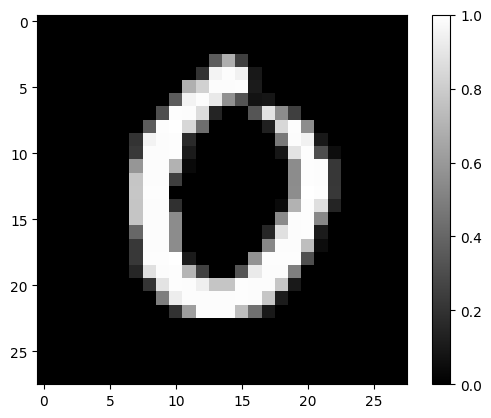

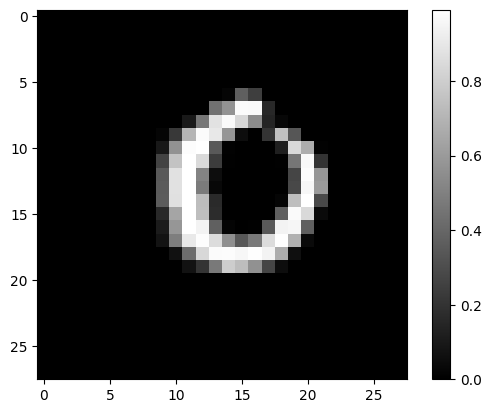

In [8]:
t_imges = v2.RandomPerspective(distortion_scale=0.6, p=1.0)(images)
plt.imshow(images[0,0],cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(t_imges[0,0],cmap='gray')
plt.colorbar()
plt.show()

## Network

In [9]:
net = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=16*5*5, out_features=120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10)
)
net = net.to(device)
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [10]:
X = torch.randn(size=(1,1,28,28), dtype = torch.float32)
X = X.to(device)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


## Hyperparameters

In [26]:
# setting hyper-parameters
learning_rate = .01
num_epochs = 10

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.Adam(net.parameters(),lr=learning_rate) # sgd

## Train a Model

epoch #: 0 train loss:  0.07000354131062826 train accuracy:  98.02999877929688 valid accuracy:  98.52999877929688
epoch #: 1 train loss:  0.05610630035400391 train accuracy:  98.41166687011719 valid accuracy:  98.48999786376953
epoch #: 2 train loss:  0.04937637329101562 train accuracy:  98.56666564941406 valid accuracy:  98.2300033569336


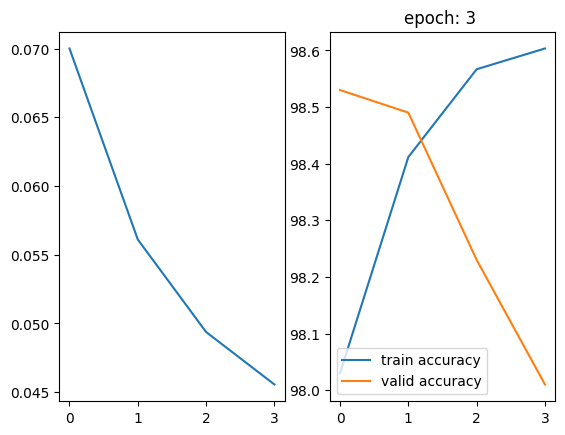

epoch #: 3 train loss:  0.04555967013041178 train accuracy:  98.60333251953125 valid accuracy:  98.01000213623047
epoch #: 4 train loss:  0.048025506337483724 train accuracy:  98.6933364868164 valid accuracy:  98.62000274658203
epoch #: 5 train loss:  0.04180742899576823 train accuracy:  98.79000091552734 valid accuracy:  98.75
epoch #: 6 train loss:  0.04011809984842936 train accuracy:  98.90666961669922 valid accuracy:  98.7699966430664
epoch #: 7 train loss:  0.03672619501749674 train accuracy:  98.97333526611328 valid accuracy:  98.27999877929688
epoch #: 8 train loss:  0.04226258595784505 train accuracy:  98.86499786376953 valid accuracy:  98.33000183105469
epoch #: 9 train loss:  0.031796286900838217 train accuracy:  99.1433334350586 valid accuracy:  98.44999694824219


In [27]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
  i=0
  l_epoch = 0
  correct = 0
  for X,y in train_iter:
    i=i+1
    X,y = X.to(device),y.to(device) # GPU
    alg.zero_grad()
    y_hat=net(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
    l=loss(y_hat,y)
    l_epoch+=l
    l.backward()
    alg.step()

  loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
  accs_train = np.append(accs_train,(100*correct.cpu())/len(mnist_train))

  correct = 0
  for X,y in valid_iter:
    X,y = X.to(device),y.to(device)
    y_hat = net(X)
    correct += (y_hat.argmax(dim=1)==y).sum()

  accs_valid = np.append(accs_valid,(100*correct.cpu())/len(mnist_valid))

  if epoch%8 == 3:
    plt.subplot(121)
    plt.plot(loss_train,label='train loss')
    plt.subplot(122)
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='lower left')
    plt.title('epoch: %d '%(epoch))
    plt.show()

  print('epoch #:',epoch,'train loss: ',loss_train[-1],'train accuracy: ',accs_train[-1],'valid accuracy: ',accs_valid[-1])

In [28]:
#torch.save(net.state_dict(),f'my_best_model.pth')

## Results (Validation Set)

In [29]:
i = 0
y_all=[]
y_hat_all=[]
for X,y in valid_iter:
  i=i+1
  X=X.to(device)
  y_hat = net(X)
  y_hat = y_hat.argmax(dim=1)
  y_all.append(y)
  y_hat_all.append(y_hat)
y_all = torch.cat(y_all,dim=0)
y_hat_all = torch.cat(y_hat_all,dim=0)

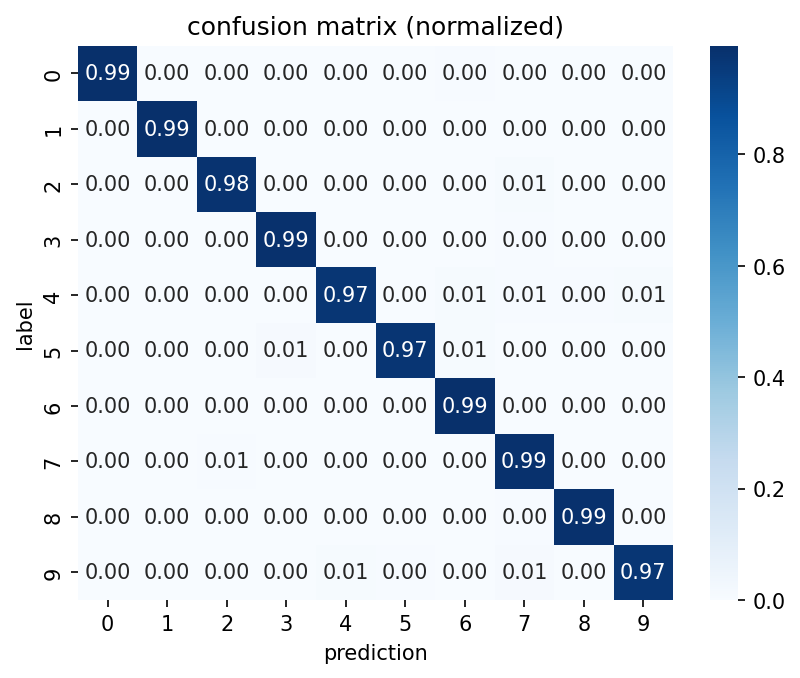

In [30]:
cf = confusion_matrix(y_all.numpy(),y_hat_all.cpu().numpy())
plt.figure(dpi=150)
cf = cf/np.sum(cf,axis=1)
sns.heatmap(cf,annot=True,cmap='Blues',fmt=".2f")
plt.title('confusion matrix (normalized)')
plt.ylabel('label')
plt.xlabel('prediction')
plt.show()

## Results (External Test Set)

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import os
import zipfile

# Google Drive 경로
path = '/content/drive/MyDrive/HUFS/24-2의료영상처리학/DIP1/DIP4E'
zip_file_path = os.path.join(path, 'hufs_mnist_2024.zip')
extract_path = '/content/hufs_mnist'

# 데이터셋 압축 해제
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print(f"Extracted to {extract_path}")
else:
    print(f"Data already extracted at {extract_path}")

Extracted to /content/hufs_mnist


In [32]:
!unzip hufs_mnist_2024 -d hufs_mnist_2024

unzip:  cannot find or open hufs_mnist_2024, hufs_mnist_2024.zip or hufs_mnist_2024.ZIP.


In [33]:
transform_test = v2.Compose(
    [
        v2.Grayscale(),
        v2.Resize((32,32)),
        v2.CenterCrop(28),
        v2.ToTensor()
    ])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [34]:
path_test = '/content/hufs_mnist' # replace with your path
data_test = ImageFolder(root=path_test,transform=transform_test)
#net.load_state_dict(torch.load(f'my_best_model.pth'))

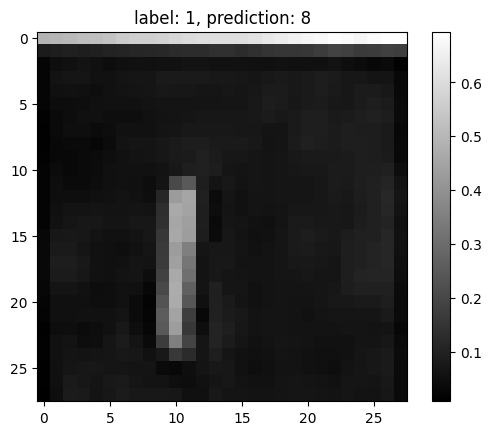

In [35]:
n=80
X = 1-data_test[n][0].unsqueeze(0)
y = data_test[n][1]
y_hat = net(X.to(device))
y_hat = y_hat.argmax(dim=1)
plt.imshow(X[0,0],cmap='gray')
plt.title(f'label: {y}, prediction: {y_hat.cpu().numpy()[0]}')
plt.colorbar()
plt.show()

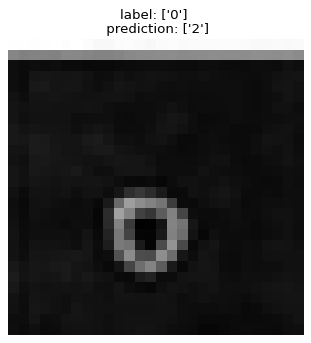

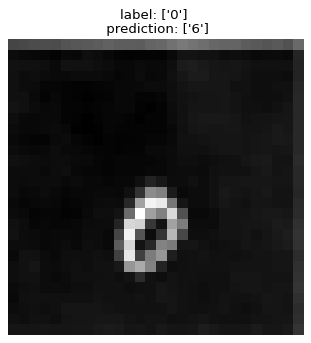

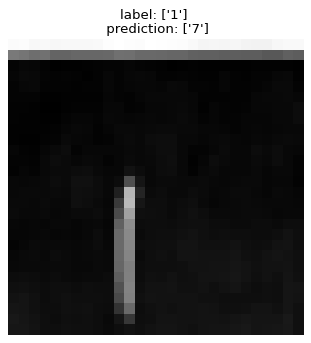

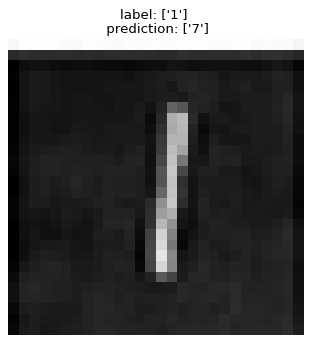

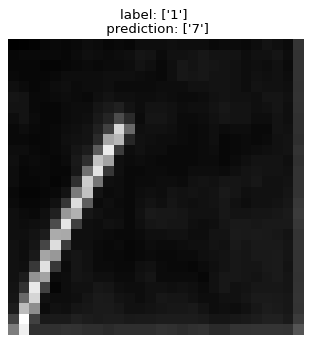

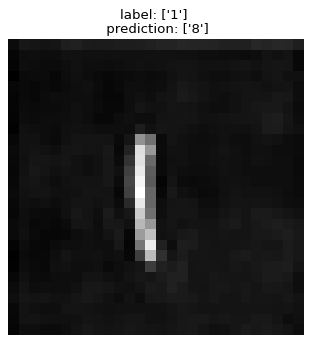

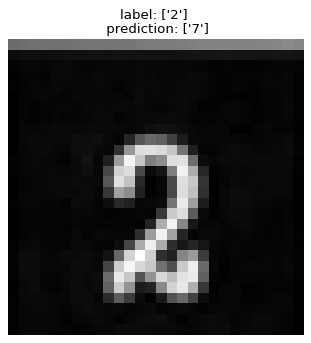

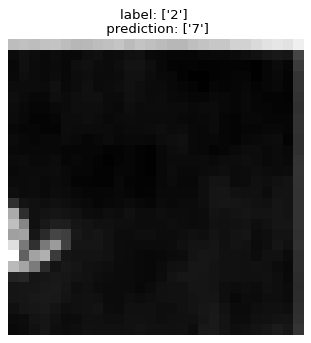

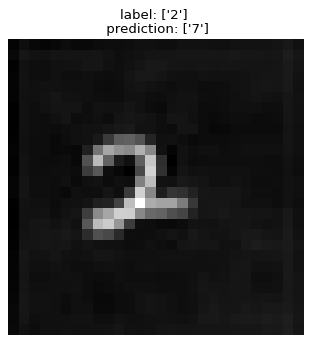

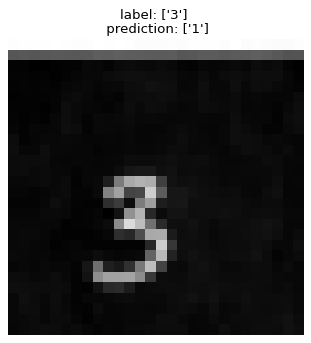

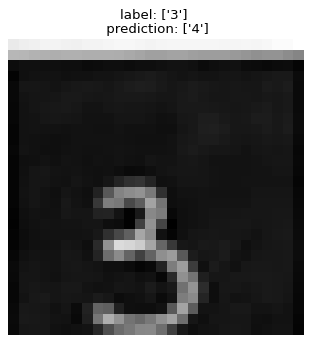

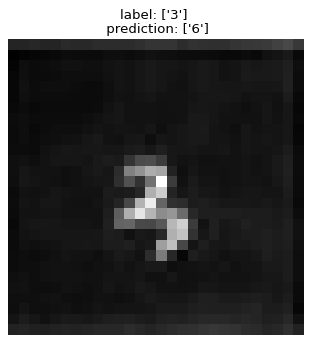

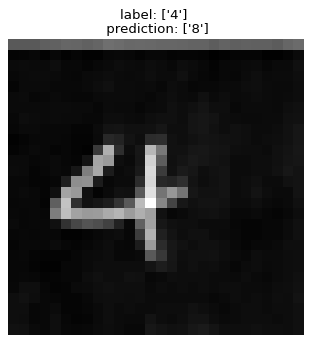

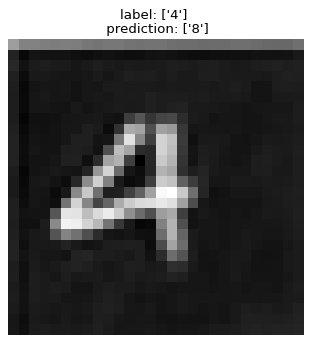

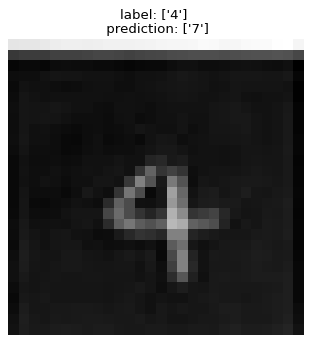

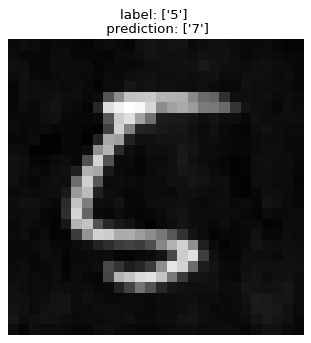

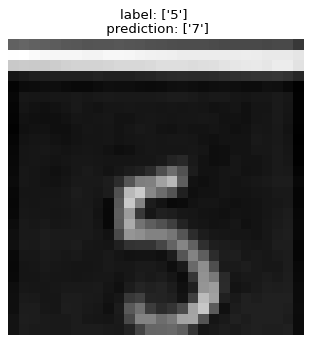

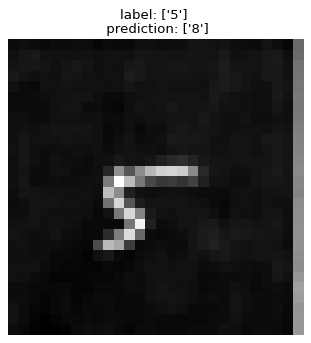

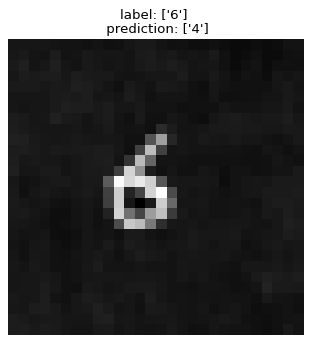

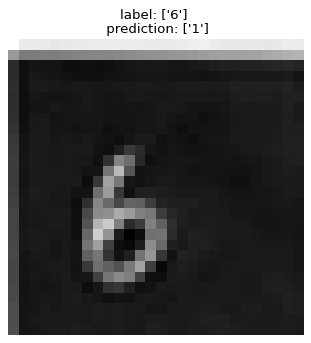

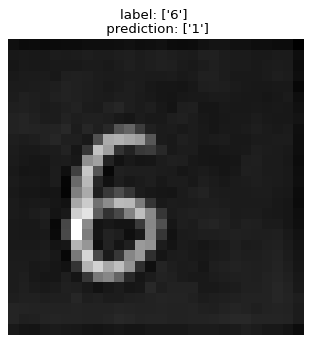

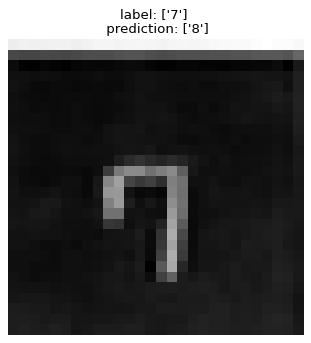

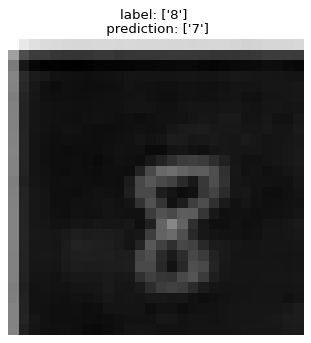

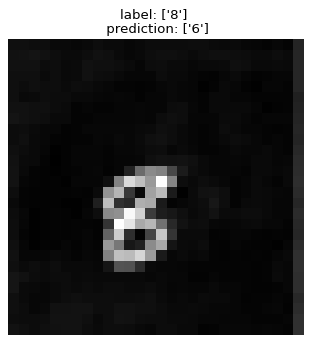

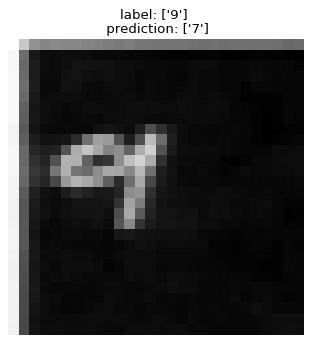

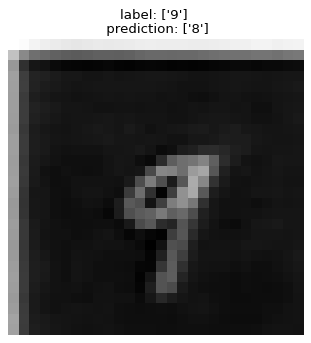

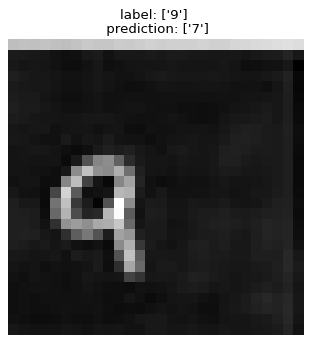

accuracy: 18.703703703703702
number of incorrect predictions: 439
number of correct predictions: 101


In [36]:
#len(data_test)
results = np.zeros((2,len(data_test)))
num_incorrect = 0
flag_plot = 1
for n in range(len(data_test)):
  X = 1 - data_test[n][0].unsqueeze(0)
  y = data_test[n][1]
  y_hat = net(X.to(device))
  y_hat = y_hat.argmax(dim=1)

  results[0,n] = y
  results[1,n] = y_hat
  if y_hat != y:
    num_incorrect+=1
    if num_incorrect%16==0:
      if flag_plot == 1:
        plt.figure(dpi=80)
        plt.imshow(X[0].cpu().squeeze(),cmap='gray')
        plt.title('label: %s \n prediction: %s'%(get_mnist_labels([y]),get_mnist_labels([y_hat])))
        plt.axis('off')
        plt.show()

acc = 100*(len(data_test)-num_incorrect)/len(data_test)
print(f'accuracy: {acc}')
print(f'number of incorrect predictions: {num_incorrect}')
print(f'number of correct predictions: {len(data_test)-num_incorrect}')

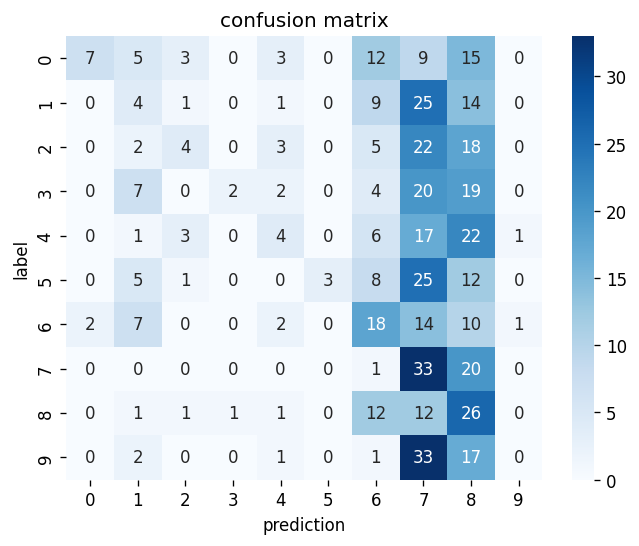

In [37]:
cf = confusion_matrix(results[0,:],results[1,:])
plt.figure(dpi=120)
sns.heatmap(cf,annot=True,cmap='Blues')
plt.title('confusion matrix')
plt.ylabel('label')
plt.xlabel('prediction')
plt.show()

## Homework
- transform, model, hyperparameter 등을 적절하게 수정하여 external test set에 대한 accuracy를 높여보자.

학습은 mnist 로 hufs는 테스트로만 진행
